In [1]:
import torch
import torchvision
import torchvision.models as models
from torchvision.models.resnet import model_Weights
import lightning.pytorch as pl

from mymodels import Model_Wrapper, Preprocess
from myutils import View, sample_imgs_list

In [2]:
# configs to speed up training
torch.set_float32_matmul_precision('medium')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [3]:
PATH_TO_IMAGENET = '../../datasets/imagenet/2012/'

In [4]:
model = models.resnet50(weights=model_Weights.DEFAULT)
model = Model_Wrapper(model)
# trainer = pl.Trainer(accelerator="auto", limit_test_batches=100)
trainer = pl.Trainer(accelerator="auto")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
def compare_ds(model, datasets, labels, view_img_slice, view_only=False, figsize=(12,6), verbose=True, skip_results:list=[0]):
    results = {}
    samples = []
    #display first
    for ds in datasets:
        samples.append(sample_imgs_list(ds, view_img_slice))
    _ = View.compare_color(samples, labels, figsize=figsize)
    
    if not view_only:
        for i in range(len(datasets)):
            if i in skip_results:
                continue
            result = trainer.test(model, datasets[i], verbose=verbose)
            results[labels[i]] = result
        return results
    else:
        return None
    

In [6]:
# get transforms
prep = Preprocess(PATH_TO_IMAGENET, (224, 224), shuffle=True)
preview_img_slice = [1, 7000, 35906, 43001, 35289]

##### Test On Orignal Dataset

<Figure size 1200x600 with 0 Axes>

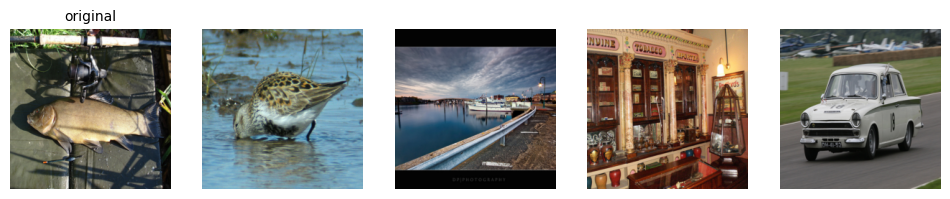

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-09-29 13:48:45.572174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 13:48:45.904032: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-29 13:48:46.751804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jon/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-09-29 13:48:46.752135: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load 

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    60.157379150390625     │
│      Pixel Val MEAN       │     112.5663070678711     │
│       Pixel Val STD       │    54.292476654052734     │
│        Top 1 Acc %        │     78.47599792480469     │
│        Top 5 Acc %        │     94.20800018310547     │
└───────────────────────────┴───────────────────────────┘

In [7]:
prep.reset_trans()
imgnet_orig = prep.get_loader()
sample_orig = sample_imgs_list(imgnet_orig, preview_img_slice)# test model on original images
View.compare_color([sample_orig], ['original'], figsize=(12,6))
result_orig = trainer.test(model, imgnet_orig)

##### Test filters on Orignal Dataset

<Figure size 1200x600 with 0 Axes>

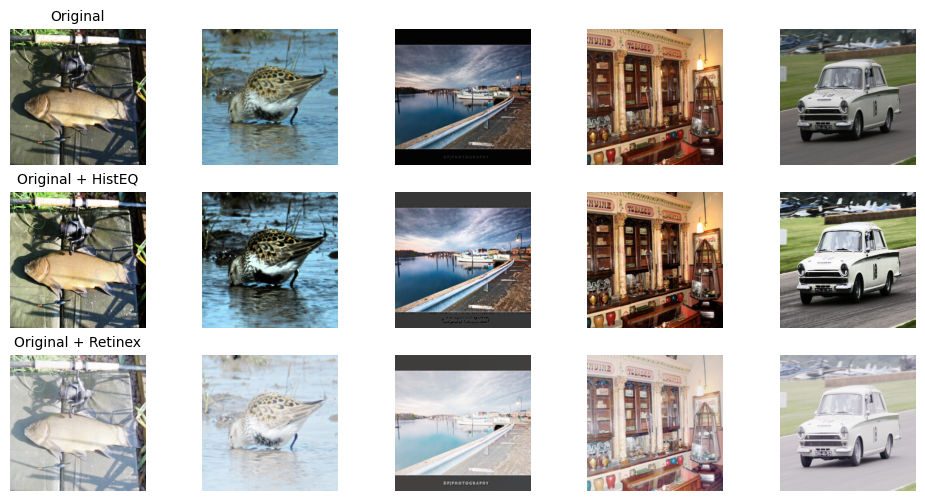

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     53.44757080078125     │
│      Pixel Val MEAN       │     109.9665298461914     │
│       Pixel Val STD       │     68.23375701904297     │
│        Top 1 Acc %        │     75.14399719238281     │
│        Top 5 Acc %        │     92.37000274658203     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     46.70280075073242     │
│      Pixel Val MEAN       │    185.86892700195312     │
│       Pixel Val STD       │    40.901145935058594     │
│        Top 1 Acc %        │     74.7760009765625      │
│        Top 5 Acc %        │     92.11799621582031     │
└───────────────────────────┴───────────────────────────┘

In [9]:
prep.reset_trans()
imgnet = prep.get_loader()
imgnet_histeq = prep.copy().hist_eq().get_loader()
imgnet_retinex = prep.copy().retinex('SSR', 100).get_loader()
imgnet_results = compare_ds(model, 
                                 [imgnet, imgnet_histeq, imgnet_retinex],
                                 ['Original', 'Original + HistEQ', 'Original + Retinex'], 
                                 preview_img_slice,
                                 view_only=False)

##### Test on Dark Images

<Figure size 1200x600 with 0 Axes>

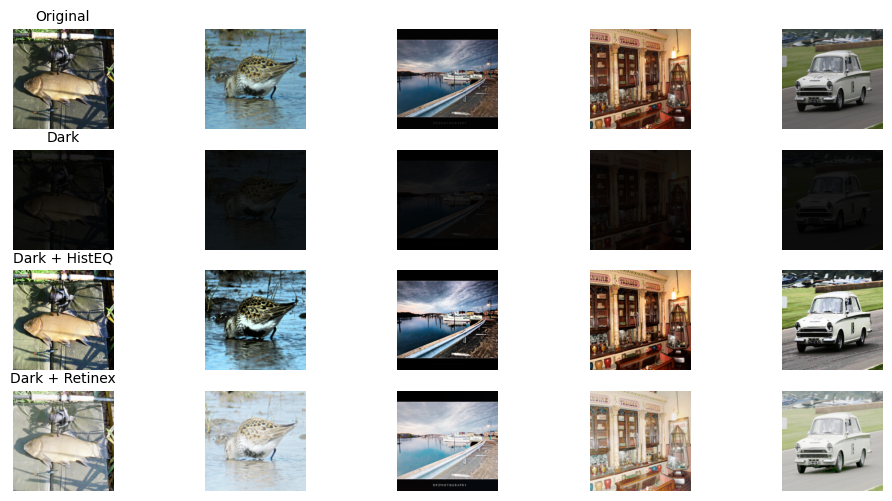

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    60.173545837402344     │
│      Pixel Val MEAN       │    14.070796012878418     │
│       Pixel Val STD       │     6.786554336547852     │
│        Top 1 Acc %        │           78.5            │
│        Top 5 Acc %        │     94.23400115966797     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     53.81348419189453     │
│      Pixel Val MEAN       │     113.7828598022461     │
│       Pixel Val STD       │     69.92774200439453     │
│        Top 1 Acc %        │     75.13999938964844     │
│        Top 5 Acc %        │     92.4260025024414      │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/f_storage/ml/grad_poster/retinex/code/retinex.py:107: RuntimeWarning: invalid value encountered in divide
  stretch=(R-mmin)/(mmax-mmin)*255 #linear stretch
/f_storage/ml/grad_poster/retinex/code/retinex.py:108: RuntimeWarning: invalid value encountered in cast
  ret[...,i]=stretch


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     49.40758514404297     │
│      Pixel Val MEAN       │    172.06321716308594     │
│       Pixel Val STD       │     46.7293815612793      │
│        Top 1 Acc %        │     75.68199920654297     │
│        Top 5 Acc %        │     92.80599975585938     │
└───────────────────────────┴───────────────────────────┘

In [10]:
prep.reset_trans()
imgnet_dark = prep.luminance(1/8).get_loader()
imgnet_dark_histeq = prep.copy().hist_eq().get_loader()
imgnet_dark_retinex = prep.copy().retinex('SSR', 100).get_loader()
imgnet_dark_results = compare_ds(model, 
                                 [prep.basic_loader(), imgnet_dark, imgnet_dark_histeq, imgnet_dark_retinex],
                                 ['Original', 'Dark', 'Dark + HistEQ', 'Dark + Retinex'], 
                                 preview_img_slice,
                                 view_only=False)

##### Test on Over Exposed Images

<Figure size 1200x600 with 0 Axes>

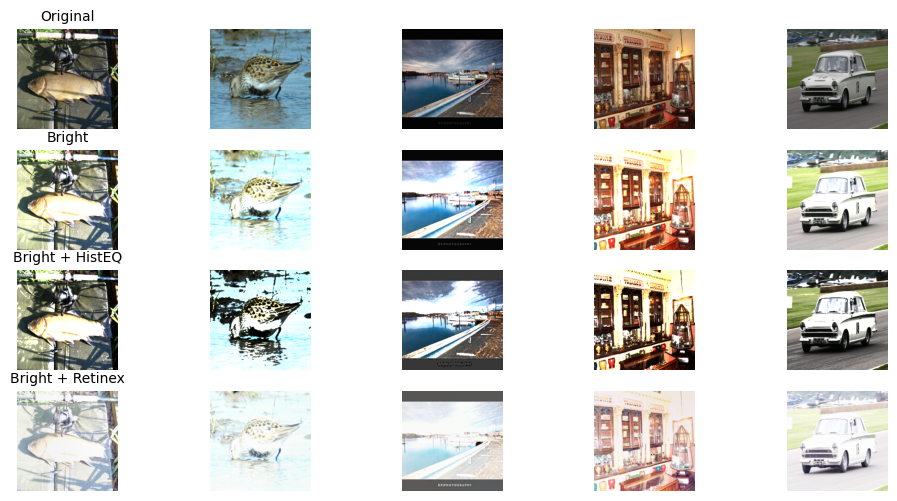

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     43.47600555419922     │
│      Pixel Val MEAN       │     179.0238037109375     │
│       Pixel Val STD       │     65.11385345458984     │
│        Top 1 Acc %        │     71.1259994506836      │
│        Top 5 Acc %        │     89.55000305175781     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     37.59737777709961     │
│      Pixel Val MEAN       │    153.71876525878906     │
│       Pixel Val STD       │     88.6029281616211      │
│        Top 1 Acc %        │     62.5620002746582      │
│        Top 5 Acc %        │     83.31400299072266     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    33.876258850097656     │
│      Pixel Val MEAN       │    211.12460327148438     │
│       Pixel Val STD       │     38.86591720581055     │
│        Top 1 Acc %        │     64.85800170898438     │
│        Top 5 Acc %        │     85.24400329589844     │
└───────────────────────────┴───────────────────────────┘

In [11]:
prep.reset_trans()
imgnet_bright = prep.luminance(2).get_loader()
imgnet_bright_histeq = prep.copy().hist_eq().get_loader()
imgnet_bright_retinex = prep.copy().retinex('SSR', 100).get_loader()
imgnet_bright_results = compare_ds(model, 
                                 [prep.basic_loader(), imgnet_bright, imgnet_bright_histeq, imgnet_bright_retinex],
                                 ['Original', 'Bright', 'Bright + HistEQ', 'Bright + Retinex'], 
                                 preview_img_slice)

##### Test on hazy images

<Figure size 1200x600 with 0 Axes>

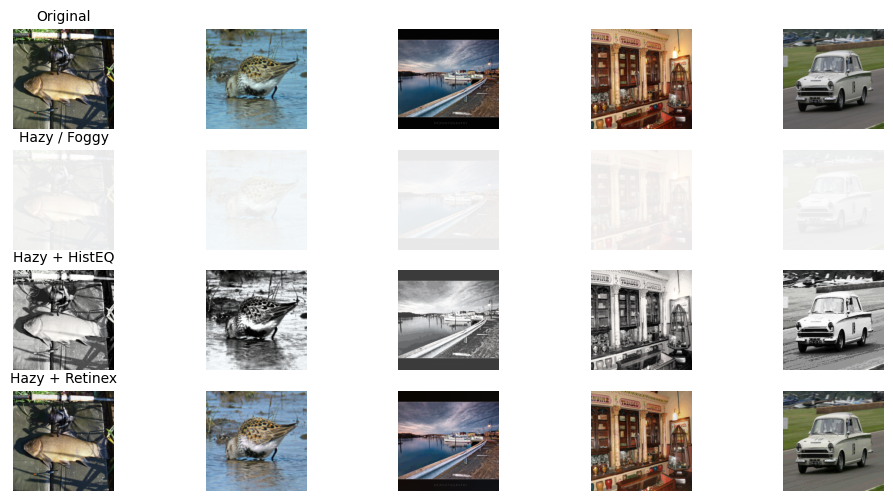

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     32.39512252807617     │
│      Pixel Val MEAN       │    242.51182556152344     │
│       Pixel Val STD       │     4.943137168884277     │
│        Top 1 Acc %        │     63.32400131225586     │
│        Top 5 Acc %        │     84.13999938964844     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     41.50328826904297     │
│      Pixel Val MEAN       │     135.5690460205078     │
│       Pixel Val STD       │     75.22123718261719     │
│        Top 1 Acc %        │     70.11799621582031     │
│        Top 5 Acc %        │     89.37200164794922     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    54.080718994140625     │
│      Pixel Val MEAN       │     115.7227783203125     │
│       Pixel Val STD       │     51.81000518798828     │
│        Top 1 Acc %        │     77.98400115966797     │
│        Top 5 Acc %        │     93.80799865722656     │
└───────────────────────────┴───────────────────────────┘

In [12]:
prep.reset_trans()
imgnet_mod = prep.fog(10).get_loader()
imgnet_mod_histeq = prep.copy().hist_eq().get_loader()
imgnet_mod_retinex = prep.copy().retinex('SSR', 100).get_loader()
imgnet_mod_results = compare_ds(model, 
                                 [prep.basic_loader(), imgnet_mod, imgnet_mod_histeq, imgnet_mod_retinex],
                                 ['Original', 'Hazy / Foggy', 'Hazy + HistEQ', 'Hazy + Retinex'], 
                                 preview_img_slice,
                                 view_only=False)

##### Test on Dark Rainy Images

<Figure size 1200x600 with 0 Axes>

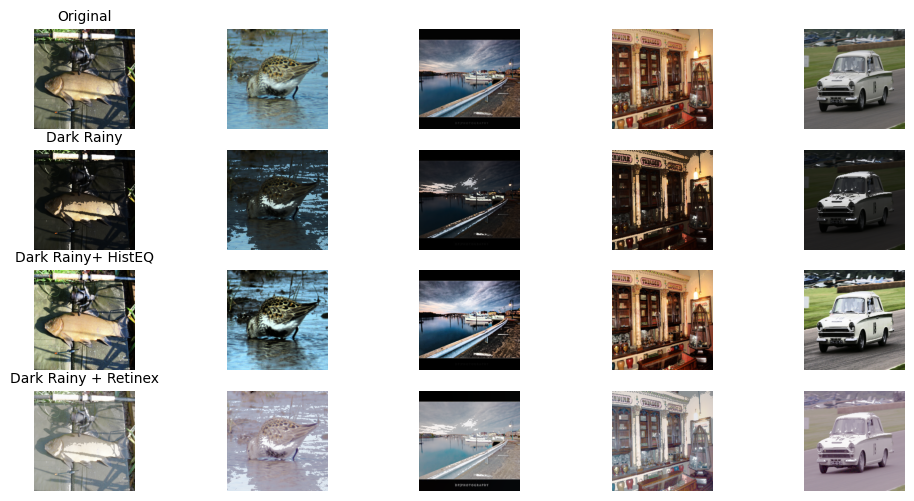

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     46.44789123535156     │
│      Pixel Val MEAN       │     66.9732666015625      │
│       Pixel Val STD       │    61.008148193359375     │
│        Top 1 Acc %        │     71.1500015258789      │
│        Top 5 Acc %        │     90.23799896240234     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     54.19770431518555     │
│      Pixel Val MEAN       │    109.54242706298828     │
│       Pixel Val STD       │     68.39167785644531     │
│        Top 1 Acc %        │     75.46600341796875     │
│        Top 5 Acc %        │     92.44200134277344     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    39.336647033691406     │
│      Pixel Val MEAN       │     157.4610137939453     │
│       Pixel Val STD       │     45.19939041137695     │
│        Top 1 Acc %        │     71.12200164794922     │
│        Top 5 Acc %        │     90.26000213623047     │
└───────────────────────────┴───────────────────────────┘

In [13]:
prep.reset_trans()
imgnet_mod = prep.rain(2, 75).get_loader()
imgnet_mod_histeq = prep.copy().hist_eq().get_loader()
imgnet_mod_retinex = prep.copy().retinex('SSR', 100).get_loader()
imgnet_mod_results = compare_ds(model, 
                                 [prep.basic_loader(), imgnet_mod, imgnet_mod_histeq, imgnet_mod_retinex],
                                 ['Original', 'Dark Rainy', 'Dark Rainy+ HistEQ', 'Dark Rainy + Retinex'], 
                                 preview_img_slice,
                                 view_only=False)

##### Test Histogram Eq on Low Contrast Images

In [14]:
# prep.reset_trans()
# imgnet_low_cont = prep.brightness_contrast(0,5).get_loader()
# imgnet_low_cont_histeq = prep.copy().hist_eq().get_loader()
# imgnet_low_cont_retinex = prep.copy().retinex('SSR', 100).get_loader()
# imgnet_low_cont_results = compare_ds(model, 
#                                  [prep.basic_loader(), imgnet_low_cont, imgnet_low_cont_histeq, imgnet_low_cont_retinex],
#                                  ['Original', 'Low Contrast', 'Low Contrast + HistEQ', 'Low Contrast + Retinex'], 
#                                  preview_img_slice)

##### Test Remapping Distribution to be low contrast

In [15]:
# prep.reset_trans()
# imgnet_mod = prep.dist_remap(20/255,20/255).get_loader()
# imgnet_mod_histeq = prep.copy().hist_eq().get_loader()
# imgnet_mod_retinex = prep.copy().retinex('SSR', 100).get_loader()
# imgnet_mod_results = compare_ds(model, 
#                                  [prep.basic_loader(), imgnet_mod, imgnet_mod_histeq, imgnet_mod_retinex],
#                                  ['Original', 'Low Contrast', 'Low Contrast + HistEQ', 'Low Contrast + Retinex'], 
#                                  preview_img_slice,
#                                  view_only=False)

: 